<a href="https://colab.research.google.com/github/FernandoRizo/Spam_classifier/blob/main/FiltroSpam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nbstripout


# Modelo keras

In [10]:
!pip install -U datasets scikit-learn
!pip install -q huggingface_hub
!pip install -q datasets



In [14]:
import re, os, glob, numpy as np, pandas as pd, tensorflow as tf
import pandas as pd
from datasets import load_dataset
import re, unicodedata
from sklearn.model_selection import StratifiedShuffleSplit
from huggingface_hub import hf_hub_download
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, precision_recall_fscore_support
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
from huggingface_hub import login

# https://huggingface.co/settings/tokens

login()

In [15]:



def clean_text(s: str) -> str:
    s = s or ""
    # Normalizar acentos y símbolos
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")
    s = s.lower()

    # Leet
    s = s.replace("€","e").replace("$","s").replace("@","a")
    s = re.sub(r"(?<=\w)[!¡|](?=\w)", "i", s)
    s = re.sub(r"0", "o", s)
    s = re.sub(r"1", "i", s)
    s = re.sub(r"3", "e", s)
    s = re.sub(r"4", "a", s)
    s = re.sub(r"5", "s", s)
    s = re.sub(r"7", "t", s)

    # URLs, emails, números largos
    s = re.sub(r"http\S+|www\.\S+", " URL ", s)
    s = re.sub(r"\S+@\S+", " EMAIL ", s)
    s = re.sub(r"\d{5,}", " NUM ", s)

    # Quitamos puntuación pegada dentro de tokens raros
    s = re.sub(r"[^\w\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def map_labels(series):
    mapping = {'spam':1, 'ham':0, 'Spam':1, 'Ham':0, True:1, False:0, '1':1, '0':0, 1:1, 0:0}
    try: return series.map(mapping).astype(int)
    except: return series.astype(int)

def load_from_folders(ham_dir, spam_dir):
    rows = []
    for label, d in [(0, ham_dir), (1, spam_dir)]:
        for p in glob.glob(os.path.join(d, "**/*"), recursive=True):
            if os.path.isfile(p):
                try:
                    txt = open(p, "r", encoding="utf-8", errors="ignore").read()
                    rows.append({"text": clean_text(txt), "label": label})
                except:
                    pass
    return pd.DataFrame(rows)

def load_spanish_softecapps():

    base_url = "https://huggingface.co/datasets/softecapps/spam_ham_spanish/resolve/main/"
    files = ["train.csv", "test.csv"]

    dfs = []
    print("Cargando softecapps/spam_ham_spanish vía Pandas directo...")

    for f in files:
        url = base_url + f
        try:

            df = pd.read_csv(url, encoding="utf-8", on_bad_lines='skip')
            df.columns = df.columns.str.strip().str.lower()


            rename_map = {}
            if 'mensaje' in df.columns: rename_map['mensaje'] = 'text'
            if 'texto' in df.columns: rename_map['texto'] = 'text'
            if 'tipo' in df.columns: rename_map['tipo'] = 'label'
            if 'etiqueta' in df.columns: rename_map['etiqueta'] = 'label'

            df = df.rename(columns=rename_map)

            # Filtrar
            if 'text' in df.columns and 'label' in df.columns:
                dfs.append(df[['text', 'label']])
            else:
                print(f"Advertencia: {f} no tiene columnas reconocibles tras limpieza: {df.columns}")

        except Exception as e:
            print(f"Error descargando/leyendo {url}: {e}")

    if not dfs:

        print("Intento fallido con softecapps. Probando mirror 'clara-fbn/spam_ham_spanish'...")
        try:
            from datasets import load_dataset
            ds = load_dataset("clara-fbn/spam_ham_spanish")
            df_fallback = pd.concat([ds['train'].to_pandas(), ds['test'].to_pandas()])
            df_fallback = df_fallback.rename(columns={'output':'label', 'input':'text'})
            # Mapeo común en mirrors
            if 'label' not in df_fallback.columns and 'label_text' in df_fallback.columns:
                 df_fallback['label'] = df_fallback['label_text']

            # Normalización con fallback
            return df_fallback
        except Exception as e2:
            raise RuntimeError(f"No se pudo cargar ni el original ni el mirror: {e2}")

    final_df = pd.concat(dfs, ignore_index=True)

    # Procesamiento final de etiquetas
    final_df = final_df.dropna()
    final_df['text'] = final_df['text'].astype(str).map(clean_text)

    # Mapeo de etiquetas (ham/spam -> 0/1)
    def clean_label(x):
        if isinstance(x, str):
            x = x.strip().lower()
            if 'spam' in x: return 1
            if 'ham' in x: return 0
        return int(x)

    final_df['label'] = final_df['label'].apply(clean_label)

    return final_df

def find_best_threshold(y_true, probs, target="f1"):
    if len(np.unique(y_true)) < 2:
        return 0.5, None
    best_thr, best_metric = 0.5, -1.0
    for thr in np.linspace(0.1, 0.9, 41):
        preds = (probs >= thr).astype(int)
        prec, rec, f1, _ = precision_recall_fscore_support(y_true, preds, average="binary", zero_division=0)
        metric = {"f1": f1, "precision": prec, "recall": rec}[target]
        if metric > best_metric:
            best_metric, best_thr = metric, thr
    return best_thr, best_metric


ds_en = load_dataset("bvk/ENRON-spam")
if "train" in ds_en:
    df_en = ds_en["train"].to_pandas()
    if "test" in ds_en:
        df_en = pd.concat([df_en, ds_en["test"].to_pandas()], ignore_index=True)
else:
    df_en = pd.concat([ds_en[s].to_pandas() for s in ds_en], ignore_index=True)

ds_sms = load_dataset('ucirvine/sms_spam')
df_sms = ds_sms['train'].to_pandas().rename(columns={'sms':'text','label':'label'})
df_sms['text'] = df_sms['text'].astype(str).map(clean_text)
df_sms['label'] = df_sms['label'].astype(int)

text_candidates  = ["text","content","message","body","EmailText","sms","email"]
label_candidates = ["label","spam","class","target","is_spam","Category","category"]
textcol  = next(c for c in text_candidates  if c in df_en.columns)
labelcol = next(c for c in label_candidates if c in df_en.columns)
if isinstance(df_en.loc[0, textcol], list):
    df_en[textcol] = df_en[textcol].apply(lambda x: " ".join(x))
df_en[textcol]  = df_en[textcol].astype(str).map(clean_text)
df_en[labelcol] = map_labels(df_en[labelcol])
df_en = df_en[[textcol, labelcol]].dropna().rename(columns={textcol:"text", labelcol:"label"})


df_drive = load_from_folders(
    "/content/drive/MyDrive/IA/Ham_Spam/ham",
    "/content/drive/MyDrive/IA/Ham_Spam/spam"
)
print("ENRON:", df_en.shape, "DRIVE:", df_drive.shape)


df_es = load_spanish_softecapps()
print("ES (softecapps):", df_es.shape, df_es["label"].value_counts())

# =====  train, val, test =====
X_d, y_d = df_drive["text"].values, df_drive["label"].values

sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
idx_trval, idx_test = next(sss1.split(X_d, y_d))
X_trval, X_test = X_d[idx_trval], X_d[idx_test]
y_trval, y_test = y_d[idx_trval], y_d[idx_test]

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
idx_train, idx_val = next(sss2.split(X_trval, y_trval))
X_train_drive, X_val = X_trval[idx_train], X_trval[idx_val]
y_train_drive, y_val = y_trval[idx_train], y_trval[idx_val]

print("Drive train:", np.bincount(y_train_drive), "val:", np.bincount(y_val), "test:", np.bincount(y_test))

# ===== Entrenamiento con los datasets  =====
X_train = np.concatenate([df_en["text"].values, X_train_drive, df_es["text"].values, df_sms["text"].values])
y_train = np.concatenate([df_en["label"].values, y_train_drive, df_es["label"].values, df_sms["label"].values])



train_df = pd.DataFrame({"text": X_train, "label": y_train}).drop_duplicates(subset="text")
X_train = train_df["text"].values
y_train = train_df["label"].values

print("Train combinado:", len(X_train), " | Val:", len(X_val), " | Test:", len(X_test))

# ===== Normalizar =====
max_tokens = 50000
vectorizer = tf.keras.layers.TextVectorization(
    standardize=None, split="whitespace",
    ngrams=2, max_tokens=max_tokens, output_mode="tf_idf"
)
vectorizer.adapt(tf.data.Dataset.from_tensor_slices(X_train).batch(256))
# ==== Modelo  ====
inputs = tf.keras.Input(shape=(1,), dtype=tf.string)
x = vectorizer(inputs)
x = tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC(name="auc"),
             tf.keras.metrics.Precision(name="prec"),
             tf.keras.metrics.Recall(name="rec")]
)

es  = tf.keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=4, restore_best_weights=True)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=2, min_lr=1e-5, verbose=1)

hist = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30, batch_size=256,
    callbacks=[es, rlr], verbose=1
)

# =====  Evaluación =====
probs = model.predict(X_test, batch_size=512).ravel()
best_thr, _ = find_best_threshold(y_test, probs, target="f1")
print("ROC-AUC:", roc_auc_score(y_test, probs), " PR-AUC:", average_precision_score(y_test, probs))
print("Umbral óptimo:", round(best_thr, 2))
print(confusion_matrix(y_test, (probs>=best_thr).astype(int)))
print(classification_report(y_test, (probs>=best_thr).astype(int), digits=3))


# ==== Guardar ====
save_path = "/content/drive/MyDrive/IA/Ham_Spam/mlp_spam_tf.keras"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
model.save(save_path)

# ========================= OPCIONAL ====================================
export_dir = "/content/drive/MyDrive/IA/Ham_Spam/export_serving"
model.export(export_dir)
print("SavedModel exportado a:", export_dir)

# === Guarda el vocabulario del TextVectorization ===
import pandas as pd, json, os, tensorflow as tf
vec_layer = None
for l in model.layers:
    if isinstance(l, tf.keras.layers.TextVectorization):
        vec_layer = l
        break
if vec_layer is None:
    raise RuntimeError("No encontré la capa TextVectorization en el modelo.")

voc_path = "/content/drive/MyDrive/IA/Ham_Spam/vocab.csv"
pd.Series(vec_layer.get_vocabulary()).to_csv(voc_path, index=False, header=False)
print("Vocabulario guardado en:", voc_path)

# === Calcula y guarda el umbral óptimo ===
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

def find_best_threshold(y_true, probs, target="f1"):
    best_thr, best_metric = 0.5, -1.0
    for thr in np.linspace(0.1, 0.9, 41):
        preds = (probs >= thr).astype(int)
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_true, preds, average="binary", zero_division=0
        )
        metric = {"f1": f1, "precision": prec, "recall": rec}[target]
        if metric > best_metric:
            best_metric, best_thr = metric, thr
    return float(best_thr), float(best_metric)

probs_val = model.predict(X_val, batch_size=512).ravel()
best_thr, _ = find_best_threshold(y_val, probs_val, target="f1")

thr_path = "/content/drive/MyDrive/IA/Ham_Spam/threshold.txt"
with open(thr_path, "w") as f:
    f.write(str(best_thr))
print("Umbral óptimo guardado en:", thr_path, " →", best_thr)


Repo card metadata block was not found. Setting CardData to empty.


ENRON: (33716, 2) DRIVE: (2402, 2)
Cargando softecapps/spam_ham_spanish vía Pandas directo...
ES (softecapps): (1207, 2) label
1    621
0    586
Name: count, dtype: int64
Drive train: [1199  241] val: [401  80] test: [400  81]
Train combinado: 38106  | Val: 481  | Test: 481
Epoch 1/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - auc: 0.8891 - loss: 0.9096 - prec: 0.7941 - rec: 0.8359 - val_auc: 0.9930 - val_loss: 0.8952 - val_prec: 0.8495 - val_rec: 0.9875 - learning_rate: 0.0010
Epoch 2/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - auc: 0.9914 - loss: 0.4651 - prec: 0.9433 - rec: 0.9699 - val_auc: 0.9987 - val_loss: 1.0357 - val_prec: 0.9756 - val_rec: 1.0000 - learning_rate: 0.0010
Epoch 3/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - auc: 0.9960 - loss: 0.4077 - prec: 0.9734 - rec: 0.9780 - val_auc: 0.9799 - val_loss: 0.9936 - val_prec: 0.9868 - val_rec: 0.9375 - learning_rate: 0.0010
Epoch 4/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc: 0.9973 - loss: 0.1315 - prec: 0.9816 

# TESTEAR

In [23]:


# ejemplos_raw = [
#   "¡Gana DIN€RO ráp1do! Cl!ck aQUI → http://x.co",
#   "Hola, adjunto las minutas de la reunión en PDF.",
#   "ÚLTIMA OPORTUNIDAD!!! transfIER3 $ a esta cu3nta",
#   "Estimado, confirmo la cita de mañana a las 10:00."
# ]
# ejemplos = [clean_text(s) for s in ejemplos_raw]

# Xej = tf.constant(ejemplos, dtype=tf.string)[:, None]
# probs = model(Xej, training=False).numpy().ravel()
# preds = (probs >= 0.54).astype(int)   # usa tu umbral óptimo
import tensorflow as tf
import numpy as np
import pandas as pd
import re, unicodedata


def clean_text(s: str) -> str:
    s = s or ""
    s = unicodedata.normalize("NFKD", s).encode("ascii","ignore").decode("ascii")
    s = s.lower()
    s = s.replace("€","e").replace("$","s").replace("@","a")
    s = re.sub(r"(?<=\w)[!¡|](?=\w)", "i", s)
    s = re.sub(r"0","o", s); s = re.sub(r"1","i", s); s = re.sub(r"3","e", s)
    s = re.sub(r"4","a", s); s = re.sub(r"5","s", s); s = re.sub(r"7","t", s)
    s = re.sub(r"http\S+|www\.\S+", " URL ", s)
    s = re.sub(r"\S+@\S+", " EMAIL ", s)
    s = re.sub(r"\d{5,}", " NUM ", s)
    s = re.sub(r"[^\w\s]", " ", s)
    s = re.sub(r"\s+"," ", s).strip()
    return s

def _try_map_label(col: pd.Series):
    s = col.astype(str).str.strip().str.lower()
    m = s.map({"spam":1, "ham":0})
    if set(s.unique()) <= {"0","1"}:
        return s.astype(int)
    if m.notna().mean() > 0.95:
        return m.astype(int)
    return None

def load_test_any_csv(path: str) -> pd.DataFrame:
    """Devuelve un DF con columnas: text (str) y, si existe, label (int)."""
    try:
        df = pd.read_csv(path, encoding="utf-8", on_bad_lines="skip")
    except UnicodeDecodeError:
        df = pd.read_csv(path, encoding="latin-1", on_bad_lines="skip")
    df.columns = [c.strip().lower() for c in df.columns]


    textcol  = next((c for c in ["text","mensaje","sms","content","body","email","input"] if c in df.columns), None)
    labelcol = next((c for c in ["label","tipo","spam","is_spam","target","output","etiqueta","category"] if c in df.columns), None)
    if textcol is not None:
        out = {"text": df[textcol].astype(str)}
        if labelcol is not None:
            mapped = _try_map_label(df[labelcol])
            if mapped is not None:
                out["label"] = mapped
        return pd.DataFrame(out).dropna(subset=["text"])


    df = df.dropna(how="all", axis=1)
    cols = list(df.columns)
    def avg_len(c):
        try: return df[c].astype(str).str.len().mean()
        except: return -1
    text_cand = max(cols, key=avg_len)

    label_cand = None
    for c in cols:
        if c == text_cand: continue
        mapped = _try_map_label(df[c])
        if mapped is not None:
            label_cand = c
            break

    out = {"text": df[text_cand].astype(str)}
    if label_cand is not None:
        out["label"] = _try_map_label(df[label_cand]).astype(int)
    return pd.DataFrame(out).dropna(subset=["text"])


def predict_texts(model, texts, threshold=0.58):
    X = [clean_text(t) for t in texts]
    Xtf = tf.constant(X, dtype=tf.string)[:, None]
    probs = model(Xtf, training=False).numpy().ravel()
    preds = (probs >= float(threshold)).astype(int)
    return probs, preds

df_test = load_test_any_csv("/content/drive/MyDrive/IA/Ham_Spam/Test/datalab_export_2025-11-17 15_46_14.csv")

probs, preds = predict_texts(model, df_test["text"].tolist())
if "label" in df_test.columns:
    from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
    y = df_test["label"].astype(int).values
    print("ROC-AUC:", roc_auc_score(y, probs))
    print("PR-AUC :", average_precision_score(y, probs))
    print("Confusion:\n", confusion_matrix(y, preds))
    print(classification_report(y, preds, digits=3))
else:
    df_out = df_test.copy()
    df_out["prob_spam"] = probs
    df_out["pred"] = preds
    df_out.head()




ROC-AUC: 0.9879518072289156
PR-AUC : 0.9705882352941178
Confusion:
 [[83  0]
 [ 1 16]]
              precision    recall  f1-score   support

           0      0.988     1.000     0.994        83
           1      1.000     0.941     0.970        17

    accuracy                          0.990       100
   macro avg      0.994     0.971     0.982       100
weighted avg      0.990     0.990     0.990       100



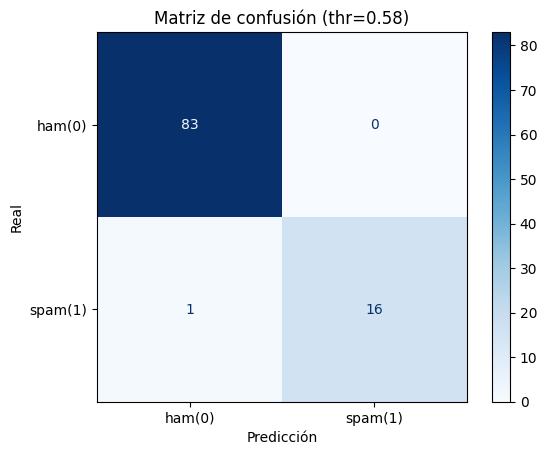

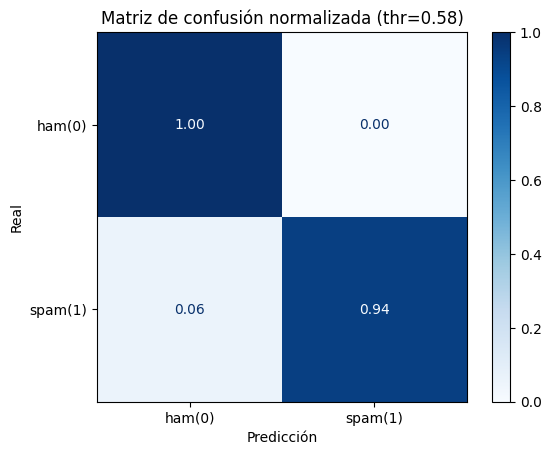

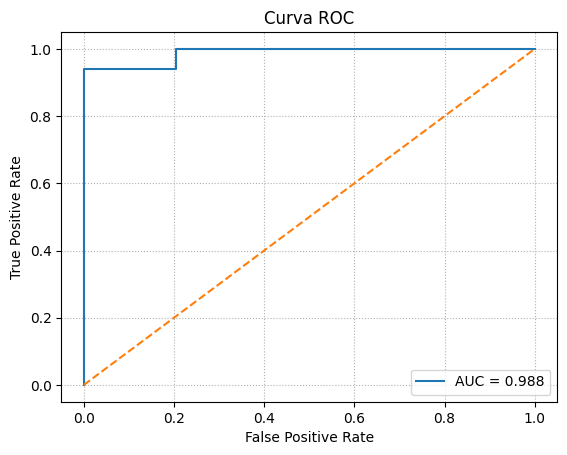

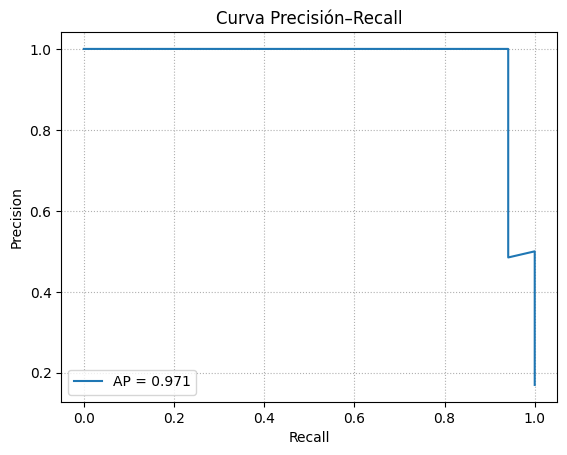

In [26]:

import tensorflow as tf
import numpy as np, pandas as pd, re, unicodedata
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score,
    precision_recall_fscore_support
)


def sweep_thresholds(y_true, probs, target="f1", goal=0.95):
    rows = []
    for thr in np.linspace(0.05, 0.95, 19):
        preds = (probs >= thr).astype(int)
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_true, preds, average="binary", zero_division=0
        )
        rows.append((thr, prec, rec, f1))
    if   target == "f1":
        best = max(rows, key=lambda r: r[3])
    elif target == "precision>=goal":
        cand = [r for r in rows if r[1] >= goal]
        best = max(cand, key=lambda r: r[1]) if cand else max(rows, key=lambda r: r[1])
    elif target == "recall>=goal":
        cand = [r for r in rows if r[2] >= goal]
        best = max(cand, key=lambda r: r[2]) if cand else max(rows, key=lambda r: r[2])
    print("thr=%.2f  precision=%.3f  recall=%.3f  f1=%.3f" % best)
    return float(best[0])

def clean_text(s: str) -> str:
    s = s or ""
    s = unicodedata.normalize("NFKD", s).encode("ascii","ignore").decode("ascii")
    s = s.lower()
    s = s.replace("€","e").replace("$","s").replace("@","a")
    s = re.sub(r"(?<=\w)[!¡|](?=\w)", "i", s)
    s = re.sub(r"0","o", s); s = re.sub(r"1","i", s); s = re.sub(r"3","e", s)
    s = re.sub(r"4","a", s); s = re.sub(r"5","s", s); s = re.sub(r"7","t", s)
    s = re.sub(r"http\S+|www\.\S+", " URL ", s)
    s = re.sub(r"\S+@\S+", " EMAIL ", s)
    s = re.sub(r"\d{5,}", " NUM ", s)
    s = re.sub(r"[^\w\s]", " ", s)
    s = re.sub(r"\s+"," ", s).strip()
    return s

def _try_map_label(col: pd.Series):
    s = col.astype(str).str.strip().str.lower()
    m = s.map({"spam":1, "ham":0})
    if set(s.unique()) <= {"0","1"}: return s.astype(int)
    if m.notna().mean() > 0.95:      return m.astype(int)
    return None

def load_any_csv(path: str) -> pd.DataFrame:
    """Devuelve DF con 'text' y opcional 'label' (0/1)."""
    try:
        df = pd.read_csv(path, encoding="utf-8", on_bad_lines="skip")
    except UnicodeDecodeError:
        df = pd.read_csv(path, encoding="latin-1", on_bad_lines="skip")
    df.columns = [c.strip().lower() for c in df.columns]

    textcol  = next((c for c in ["text","mensaje","sms","content","body","email","input"] if c in df.columns), None)
    labelcol = next((c for c in ["label","tipo","spam","is_spam","target","output","etiqueta","category"] if c in df.columns), None)
    if textcol is not None:
        out = {"text": df[textcol].astype(str)}
        if labelcol is not None:
            m = _try_map_label(df[labelcol])
            if m is not None: out["label"] = m
        return pd.DataFrame(out).dropna(subset=["text"])

    df = df.dropna(how="all", axis=1)
    cols = list(df.columns)
    text_cand = max(cols, key=lambda c: df[c].astype(str).str.len().mean())
    out = {"text": df[text_cand].astype(str)}
    for c in cols:
        if c == text_cand: continue
        m = _try_map_label(df[c])
        if m is not None:
            out["label"] = m.astype(int)
            break
    return pd.DataFrame(out).dropna(subset=["text"])

# ---------- carga SavedModel (serving) ----------
export_dir = "/content/drive/MyDrive/IA/Ham_Spam/export_serving"
serving = tf.saved_model.load(export_dir)
infer   = serving.signatures["serving_default"]

def predict_texts_serving(texts, threshold=0.58):
    X = [clean_text(t) for t in texts]
    X = tf.constant(X, dtype=tf.string)[:, None]   # (batch,1)
    out = infer(X)
    probs = list(out.values())[0].numpy().ravel()
    preds = (probs >= float(threshold)).astype(int)
    return probs, preds


def get_threshold(val_csv_path=None, threshold_txt="/content/drive/MyDrive/IA/Ham_Spam/threshold.txt",
                  target="f1", goal=0.95, default_thr=0.58):

    if val_csv_path:
        df_val = load_any_csv(val_csv_path)
        if "label" in df_val.columns:
            probs_val, _ = predict_texts_serving(df_val["text"].tolist(), threshold=0.5)
            thr = sweep_thresholds(df_val["label"].astype(int).values, probs_val,
                                   target=target, goal=goal)

            try:
                with open(threshold_txt, "w") as f: f.write(str(thr))
            except Exception: pass
            return thr
        else:
            print("El CSV de validación no trae etiquetas; no se puede optimizar umbral.")

    try:
        with open(threshold_txt) as f:
            return float(f.read().strip())
    except Exception:
        print("Usando umbral por defecto:", default_thr)
        return float(default_thr)

# ==== Ruta a archivo de prueba ====
VAL_CSV  = None
TEST_CSV = "/content/drive/MyDrive/IA/Ham_Spam/Test/datalab_export_2025-11-17 15_46_14.csv"

#UMBRAL = get_threshold(val_csv_path=VAL_CSV)
UMBRAL = 0.58
df_test = load_any_csv(TEST_CSV)
probs, preds = predict_texts_serving(df_test["text"].tolist(), threshold=UMBRAL)

# ---------- métricas y gráficas ----------
if "label" in df_test.columns:
    y = df_test["label"].astype(int).values

    # Matriz de confusión  ---
    cm = confusion_matrix(y, preds, labels=[0,1])
    disp = ConfusionMatrixDisplay(cm, display_labels=["ham(0)","spam(1)"])
    fig, ax = plt.subplots()
    disp.plot(values_format="d", cmap="Blues", ax=ax, colorbar=True)
    ax.set_title(f"Matriz de confusión (thr={UMBRAL:.2f})")
    ax.set_xlabel("Predicción"); ax.set_ylabel("Real")
    plt.show()

    # ---  Matriz normalizada  ---
    cmn = confusion_matrix(y, preds, labels=[0,1], normalize="true")
    disp_n = ConfusionMatrixDisplay(cmn, display_labels=["ham(0)","spam(1)"])
    fig, ax = plt.subplots()
    disp_n.plot(values_format=".2f", cmap="Blues", ax=ax, colorbar=True)
    ax.set_title(f"Matriz de confusión normalizada (thr={UMBRAL:.2f})")
    ax.set_xlabel("Predicción"); ax.set_ylabel("Real")
    plt.show()

    fpr, tpr, _ = roc_curve(y, probs)
    auc = roc_auc_score(y, probs)
    plt.figure(); plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}"); plt.plot([0,1],[0,1], linestyle="--")
    plt.title("Curva ROC"); plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right"); plt.grid(True, linestyle=":"); plt.show()

    prec, rec, _ = precision_recall_curve(y, probs)
    ap = average_precision_score(y, probs)
    plt.figure(); plt.plot(rec, prec, label=f"AP = {ap:.3f}")
    plt.title("Curva Precisión–Recall"); plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.legend(loc="lower left"); plt.grid(True, linestyle=":"); plt.show()
else:
    out = df_test.copy()
    out["prob_spam"] = probs
    out["pred"] = preds
    print(out.head(10))
